# Workflow to calculate the quantum efficiency of a polycrystalline material

In [2]:
import subprocess
import os
from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep


from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from python_functions import *
from bs_plotting import *
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#%matplotlib inline
bandstructure_cu = read_bands2pmg(path='./structures/GaAs_bulk/', export=False)
#print(bandstructure_cu.distance)
output = []
for kpt in bandstructure_cu.kpoints:
    output.append((kpt.label,kpt.cart_coords))
plot = get_bs_plot(bandstructure_cu,ylim = (-5,5), size = [10,8])
#plt.xlabel()
plt.savefig('./structures/plots/GaAs_bulk_bandstruct_poster.png',dpi=400)

In [ ]:
directory = './structures/Cu_surf_111/'
work_fct = 3.52958434
listOfFiles = os.listdir(directory)
for item in listOfFiles:
    if '_photo.odi' in item:
        subprocess.call(f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}',shell=True)
#subprocess.call(,)
#f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}'
#f'sed -i "s/.*slab_volume.*/slab_volume : {round(slab_vol,5)}/" {path}{item}'

In [2]:
cell = read_cell2pmg('./structures/Cu_bulk_bandstruct_full/Cu_bulk_bandstruct_full.cell')
#cell = CastepOutput('./structures/Cu_surf_111/Cu_surf_111.castep').structure
print(cell)
view(cell)

Full Formula (Cu1)
Reduced Formula: Cu
abc   :   2.560619   2.560619   2.560619
angles:  60.000013  60.000009  60.000010
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Cu      0    0    0


AttributeError: iterimages

In [ ]:
view(AseAtomsAdaptor.get_atoms(cell))

In [ ]:
file_path = './structures/Cu_surf_111_photo/Cu_surf_111.castep'
output = CastepOutput(file_path)#
print(output.structure)

In [ ]:
seed = 'Cu_bulk_spectral_pdos'
seed = 'Cu_surf_111'
eins, axis = plot_proj_dos_optados(seed, plot_down= False, plot_total= False, export_json=False,xlimit=(-10, 10))
plt.savefig('Cu111_pdos_-10_10.png',dpi=200)

In [ ]:
struct_110 = AseAtomsAdaptor.get_structure(read('./structures/Cu_surf_110/Cu_surf_110.xyz'))
latimer = KPathLatimerMunro(struct_110)
for index in range(12):
    print('Latimer_Munroe Label:', latimer.LabelSymbol(index),'Point: ', latimer.LabelPoints(index))
print('SetyawanCurtarolo/ASE',KPathSetyawanCurtarolo(struct_110).orc())

I recommend using pymatgen to generate the bulk/slab and then convert it to an ASE atom object. The advantages of this approach are:
- pymatgen has a better bulk/slab generation algorithm 
- castep can link a calculator to the Atom object


#### Download and save .cif file for necessary materials

In [12]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
## print(bulk)
print(bulk.volume)
# print(bulk.lattice)
# print(bulk.species)
# print(bulk.sites)
bulk.scale_lattice(11.94)
analyser = SpacegroupAnalyzer(bulk)
conventional = analyser.get_conventional_standard_structure()
print(conventional.lattice)
bulk_ase = AseAtomsAdaptor().get_atoms(bulk)
## print(bulk_ase)
# print(bulk)
surface = ase.build.surface(lattice = bulk_ase, indices = (1,1,1), layers = 5, vacuum=15, tol=1e-10, periodic=True)
#print(get_adjusted_kpts(bulk,AseAtomsAdaptor.get_structure(surface), [9,9,9] ))
#view.add_unitcell()
#view

11.871889685682168
3.628174 0.000000 0.000000
0.000000 3.628174 0.000000
0.000000 0.000000 3.628174


In [ ]:
surf_110 = read_cell2pmg('./structures/Cu_surfaces_debug/Cu_surf_110.cell')
view(AseAtomsAdaptor.get_atoms(surf_110))
surf_100 = read_cell2pmg('./structures/Cu_surfaces_debug/Cu_surf_100.cell')
view(AseAtomsAdaptor.get_atoms(surf_100))

#### Read the Cutoff Energy Results and Display as Graph

In [ ]:
seed = 'Cu_bulk_'
path_pbe = './structures/cutoff_convergence/'
path_sol = './structures/cutoff_convergence/PBEsol/'
cutoffs = [200, 300, 400, 500, 566, 600]
tot_energies, differences = {'pbe' : [],'pbesol' : []},{'pbe' : [],'pbesol' : []}
for cut in cutoffs:
    temp_pbe = CastepOutput(patj = f'{path_pbe}{seed}{cut}/{seed}.castep')
    temp_sol = CastepOutput(patj = f'{path_sol}{seed}{cut}/{seed}.castep')
    tot_energies['pbe'].append(temp_pbe.)
    tot_energies['pbe_sol'].append(temp_sol)

for i in range(len(tot_energies)):
    if i == 0:
        pass
    if i == len(tot_energies)-1:
        break
    differences['pbe'].append(abs(tot_energies[i+1]-tot_energies[i]))
    differences['pbe_sol'].append(abs(tot_energies[i+1]-tot_energies[i]))

#print('Differences:', differences)
#print('Total Energies:', tot_energies)
#plt.rcParams['text.usetex'] = True
sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
graph = sns.lineplot(x=cutoffs, y=differences)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'energy cutoff [eV]', ylabel = r'$\Delta E_{tot}$', title = 'Energy Cutoff Convergence')
graph.set(xlim = (390,610), ylim =  (-0.1,1.1))
plt.legend(labels=[r'$\Delta$s',r'$\frac{1}{2}kT$'])


#### Create scaled volume inputs, read the output files and create murnaghan plot

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
create_murnaghan_inputs(seed = 'Cu_bulk_murn', structure=bulk, cutoff = 600, kpoints=[16,16,16], min_max=(0.9,1.1,10))

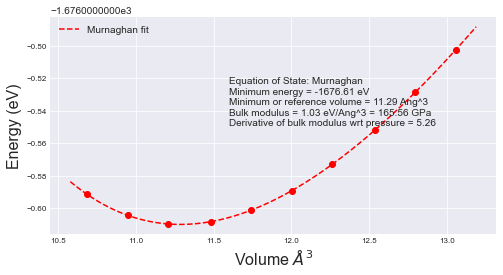

In [11]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
seed = 'Cu_bulk_murn_ext'
murn, minimal_struct, energies,volumes = read_murnaghan_outputs(seed = seed, structure = bulk,path = f'./structures/EOS_tests/PBEsol/{seed}/')
fig= murn.plot()
plt.style.use('seaborn-darkgrid')
plt.savefig(f'./structures/plots/{seed}_pbesol.png',dpi = 300)

#### Read the Results for Kpoint grid convergence and plot as graph

ToDo: Modify the Kpoint convergence generation function to make a single input and then vary the values within the PBS script

In [ ]:
seeds = ['Cu_bulk_2','Cu_bulk_4','Cu_bulk_6','Cu_bulk_8','Cu_bulk_9','Cu_bulk_10','Cu_bulk_12','Cu_bulk_14','Cu_bulk_16','Cu_bulk_18']
tot_energies = []
differences = []
kpoints = [4,6,8,9,10,12,14,16,18]
kpoints2 = kpoints[1:]
for seed in seeds:
    temp_out = CastepOutput(path = f'./structures/kpt_convergence/{seed}.castep')
    tot_energies.append(temp_out.ks_total_energy)
for i in range(len(tot_energies)):
    if i == 0:
        pass
    if i == len(tot_energies)-1:
        break
    differences.append(abs(tot_energies[i+1]-tot_energies[i]))
sns.set_theme(style="darkgrid")
differences_2 = differences[1:]
#print(differences_2)
# Plot the responses for different events and regions
graph = sns.lineplot(x=kpoints2, y=differences_2)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'MP k-point grid size (x,x,x)', ylabel = r'$\Delta E_{tot}$ [eV]', title = 'K-point Grid Convergence')
plt.legend(labels=[r'$\Delta$ E',r'$\frac{1}{2}kT$'])
#plt.savefig('./structures/plots/k_point_convergence_zoom.png',dpi = 300)

[1.4953742129758594, 1.46073047727104, 1.4169090211068478, 1.376485651218525, 1.3586890656414934, 1.3352698716466462]


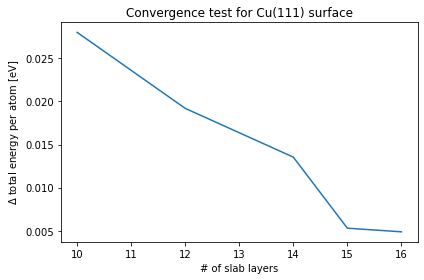

In [3]:
atoms = [8,10,12,14,15,16]

bulk_energy = -1676.5954
cell_100 = read_cell2pmg('./structures/layer_convergence/100/Cu100_geom.cell')
cell_110 = read_cell2pmg('./structures/layer_convergence/110/Cu110_geom.cell')
cell_111 = read_cell2pmg('./structures/layer_convergence/111/Cu111_geom.cell')

total_energies_100 = [-13411.42595553,-16764.64359063,-20117.86115268,-23471.07926522,-25147.68758931,-26824.29928175]
total_energies_110 = [-13410.69670576,-16763.92313970,-20117.14478342,-23470.36493049,-25146.96980282,-26823.58389667]
total_energies_111 = [-13411.73832259,-16764.95286620,-20118.17369990,-23471.39220467,-25147.99980183,-26824.61125253]

data = {
    100: [total_energies_100[i]/atoms[i] for i in range(len(atoms))],
    110: [total_energies_110[i]/atoms[i] for i in range(len(atoms))],
    111: [total_energies_111[i]/atoms[i] for i in range(len(atoms))]
}
diff = {
    100:[data[100][i-1]-data[100][i] for i in range(1,len(atoms))],
    110:[data[110][i-1]-data[110][i] for i in range(1,len(atoms))],
    111:[data[111][i-1]-data[111][i] for i in range(1,len(atoms))],
}

surf_energies = {
    100: [calc_surface_energy(bulk_energy, total_energies_100[i],atoms[i], cell_100.lattice.volume/cell_100.lattice.c) for i in range(len(atoms))],
    110: [calc_surface_energy(bulk_energy, total_energies_110[i],atoms[i], cell_110.lattice.volume/cell_110.lattice.c) for i in range(len(atoms))],
    111: [calc_surface_energy(bulk_energy, total_energies_111[i],atoms[i], cell_111.lattice.volume/cell_111.lattice.c) for i in range(len(atoms))],
}

diff_surf = {
    100:[surf_energies[100][i]-surf_energies[100][i-1] for i in range(1,len(atoms))],
    110:[surf_energies[110][i]-surf_energies[110][i-1] for i in range(1,len(atoms))],
    111:[surf_energies[111][i]-surf_energies[111][i-1] for i in range(1,len(atoms))],
}
surface = 111

print([surf_energies[surface][i]*16.02176565 for i in range(len(atoms))])

fig,ax = plt.subplots(1,1)
ax.plot(atoms[1:], diff[surface])
ax.set(xlabel='# of slab layers', ylabel = r'$\Delta$ total energy per atom [eV]', title = f'Convergence test for Cu({surface}) surface')
#ax.plot(atoms, data[surface])
#ax.set(xlabel='# of slab layers', ylabel = 'total energy per atom [eV]', title = f'Convergence test for Cu({surface})')
#ax.plot(atoms,surf_energies[surface])
#ax.set(xlabel='# of slab layers', ylabel = 'surface energy [eV]', title = f'Convergence test for Cu({surface})')
#ax.plot(atoms[1:],diff_surf[surface])
#ax.set(xlabel='# of slab layers', ylabel = r'$\Delta$ surface energy [eV]', title = f'Convergence test for Cu({surface})')
plt.tight_layout()
#plt.savefig()

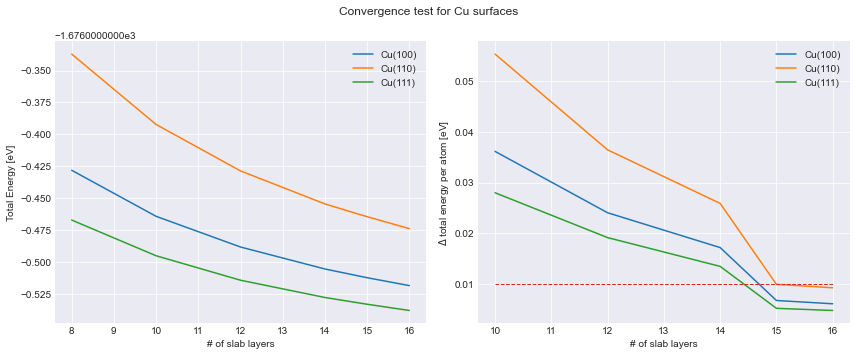

In [15]:
plt.style.use('seaborn-darkgrid')
fig,ax = plt.subplots(1,2, figsize = [12,5])
ax[0].set(xlabel='# of slab layers', ylabel = 'Total Energy [eV]')
ax[1].set(xlabel='# of slab layers', ylabel = r'$\Delta$ total energy per atom [eV]')
for item in diff:
    ax[0].plot(atoms, data[item], label = f'Cu({item})')
    ax[1].plot(atoms[1:], diff[item], label = f'Cu({item})')
ax[1].plot(atoms[1:], [0.01 for x in range(len(atoms)-1)], ls = '--', lw = 1)
plt.suptitle('Convergence test for Cu surfaces')
ax[1].legend()
ax[0].legend()
plt.tight_layout()
plt.savefig('./structures/plots/Cu_surfaces_layer_convergence_comp.png',dpi = 500)

#### Read in the geometry optimisation trajectory file

In [ ]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure

data = read_geometry_traj_file(path = './structures/')

#### Plot the electronic densities and potential

In [ ]:
fig,ax = create_density_plot(directory = './structures/Cu110_victor_60A/', centered = False)
plt.tight_layout()
plt.savefig('./structures/plots/Cu110_victor_60A_density_plot.png')

In [ ]:
fig,ax = create_potential_plot(directory='./structures/Cu111_victor_60A/', centered = False)
plt.tight_layout()
plt.savefig(f'./structures/plots/Cu110_victor_60A_potential_plot.png')

#### Create Plot with modified pymatgen functions to create more colourful bandstructure plot

#### Plot reference Cu Bandstructure from Materials Project 

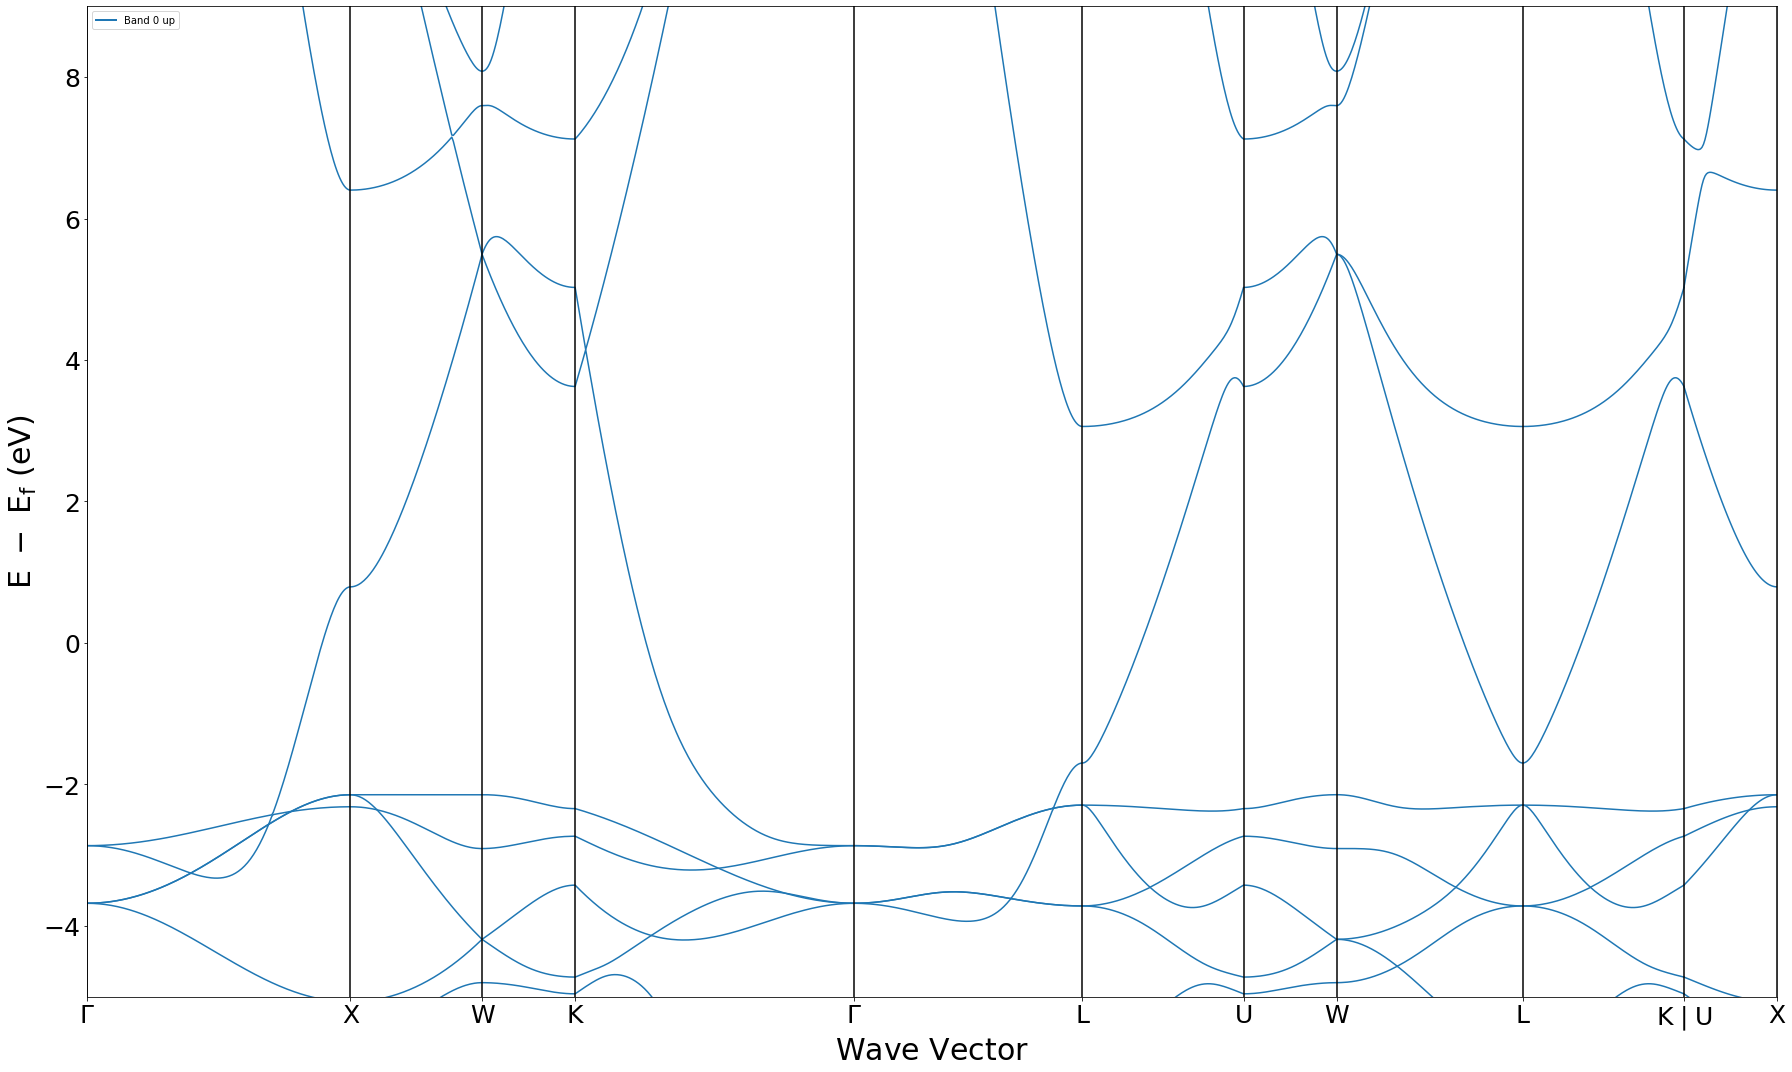

In [5]:
with open('./structures/jsons/bands/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_new = BandStructureSymmLine.from_dict(d)

plotter = BSPlotter(bandstruct_new)
#print(bandstruct_new.as_dict()['branches'])
#print(bandstruct_new.get_branch(320))
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

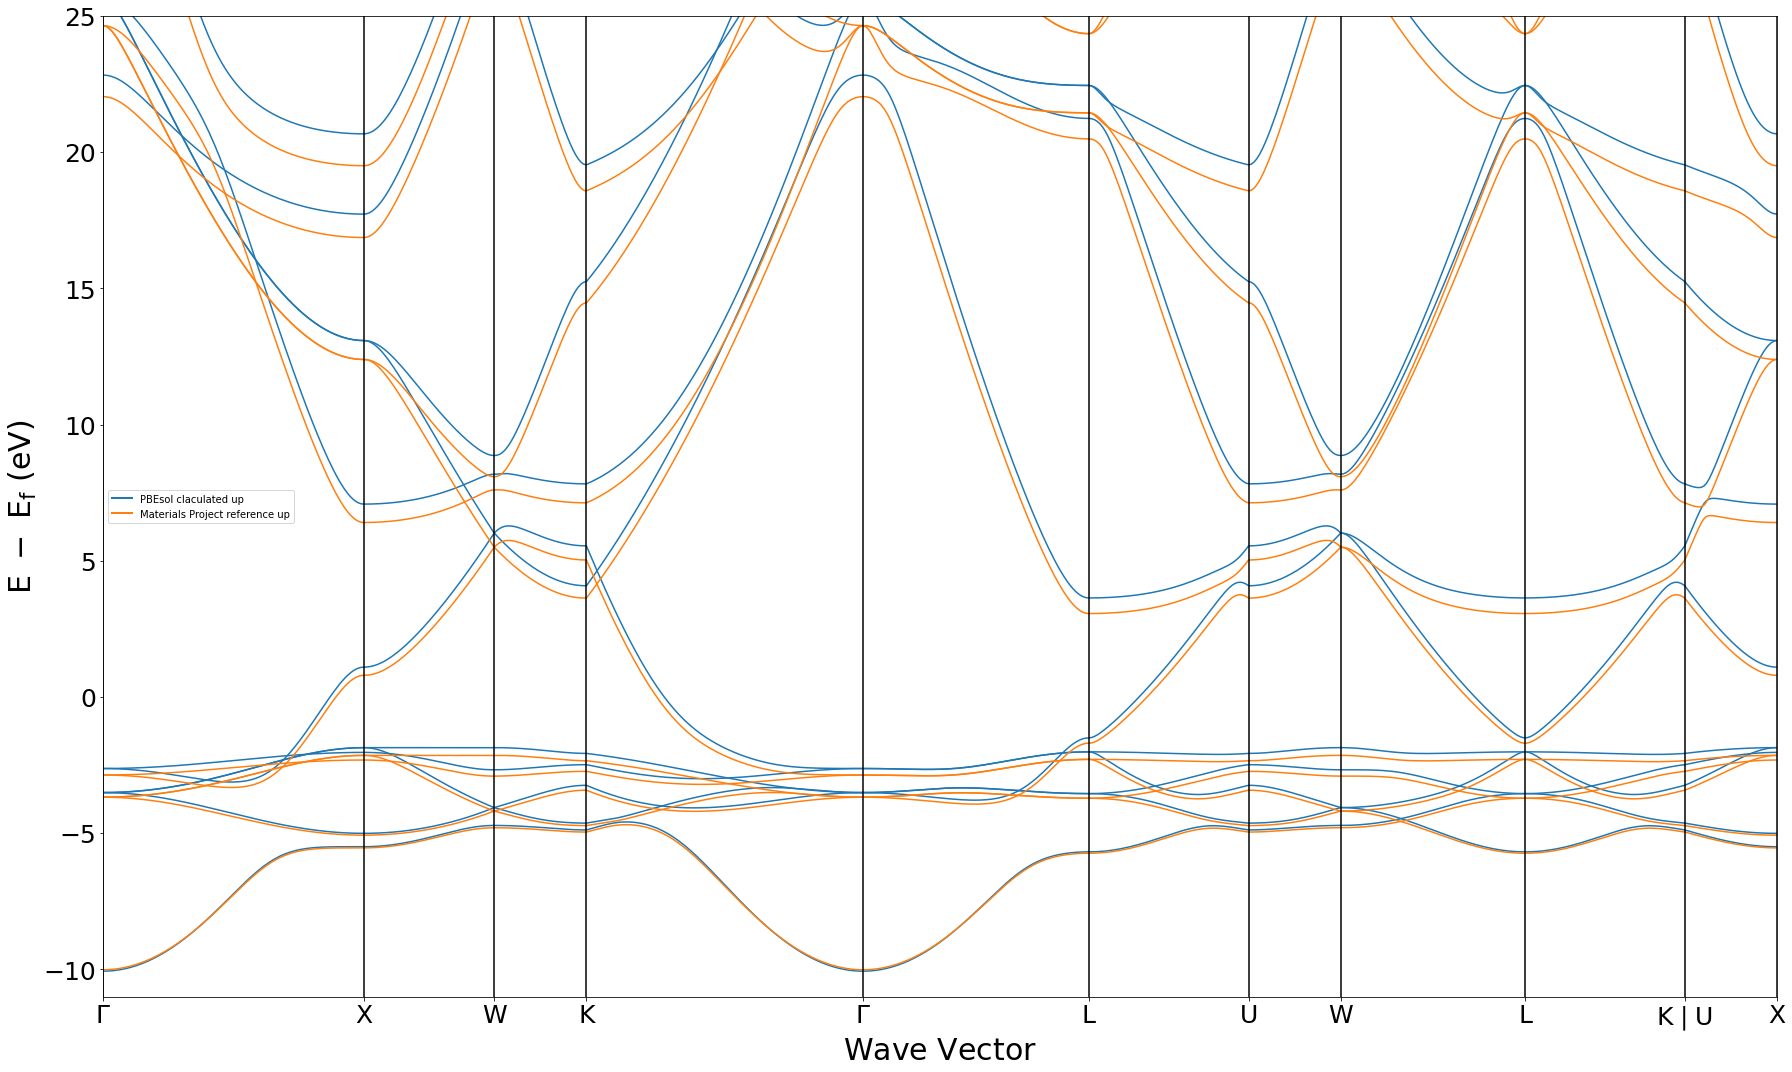

In [38]:
with open('./structures/jsons/bands/Cu_bandstruct_PBEsol.json', 'r') as f:
    d = json.load(f)
    full = BandStructureSymmLine.from_dict(d)
full.efermi = 5.2
plotter = BSPlotter(full)
plotter.add_bs(bandstruct_new)
plotter.get_plot(ylim=[-11,25], bs_labels = ['PBEsol claculated', 'Materials Project reference'])
plt.savefig('./structures/plots/Cu_bulk_pbesol_bandstruct_comp_mp_ref.png', dpi = 300)


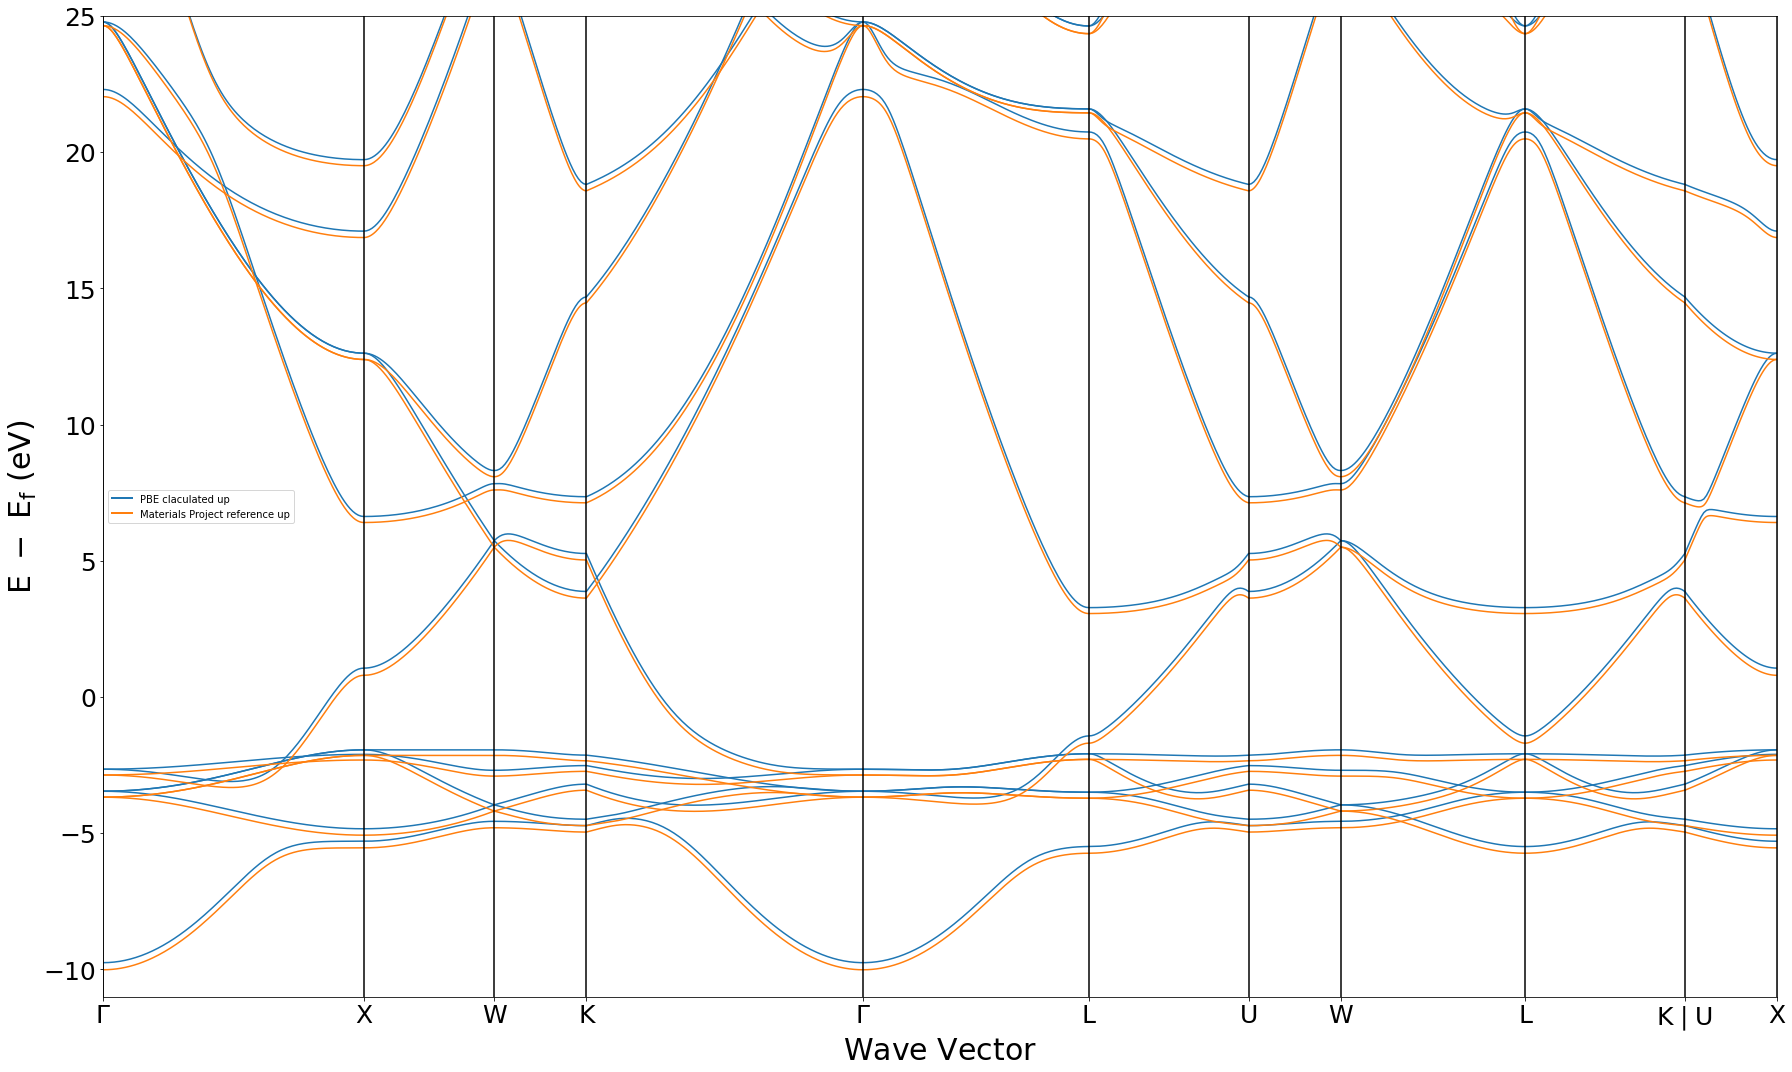

In [37]:
with open('./structures/jsons/bands/Cu_bandstruct_all_points.json', 'r') as f:
    d = json.load(f)
    full_pbe = BandStructureSymmLine.from_dict(d)
full_pbe.efermi = 5.0
plotter = BSPlotter(full_pbe)
plotter.add_bs(bandstruct_new)
plotter.get_plot(ylim=[-11,25], bs_labels = ['PBE claculated', 'Materials Project reference'])
plt.savefig('./structures/plots/Cu_bulk_pbe_bandstruct_comp_mp_ref.png', dpi = 300)

#### Plot bandstructure from castep .bands file using ASE functions

In [ ]:
#bandfile = create_bands_file(calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Fe_metal_bcc.cif")),seed = 'Fe')
seed = 'Cu_bulk_bandstruct'
calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Cu_metal_fcc.cif"))
calc = ase.calculators.castep.Castep(check_castep_version = False,keyword_tolerance=3)
calc_struct.calc = calc
bandstructure = calc_struct.calc.band_structure(bandfile=f'./structures/{seed}/{seed}.bands').subtract_reference()
#print(bandstructure.get_labels())
plt.style.use('seaborn')
#ax.ylimit(-12,35)
bandstructure.plot(emin=-12, emax=35)

#### Create Parameter Sweep for OptaDOS

In [ ]:
photoemission_options= {
        'work_function' : 4.3731,
        'surface_area' : 6.55677,
        'slab_volume' : 198.13882,
        'elec_field' : 0,
        'optics_qdir' : [1, 1.000, 1.0000],
        'photo_model' : ['1step','3step'] # 1step or 3step or 1step,3step
}
optados_photon_energy_sweep(seed='Cu_surf_110', min_max = (4,5.5,20), **photoemission_options)

In [ ]:
one = [1,2,3,4]
print(' '.join([str(x) for x in one]))

#### Read in the photon energy sweep output files

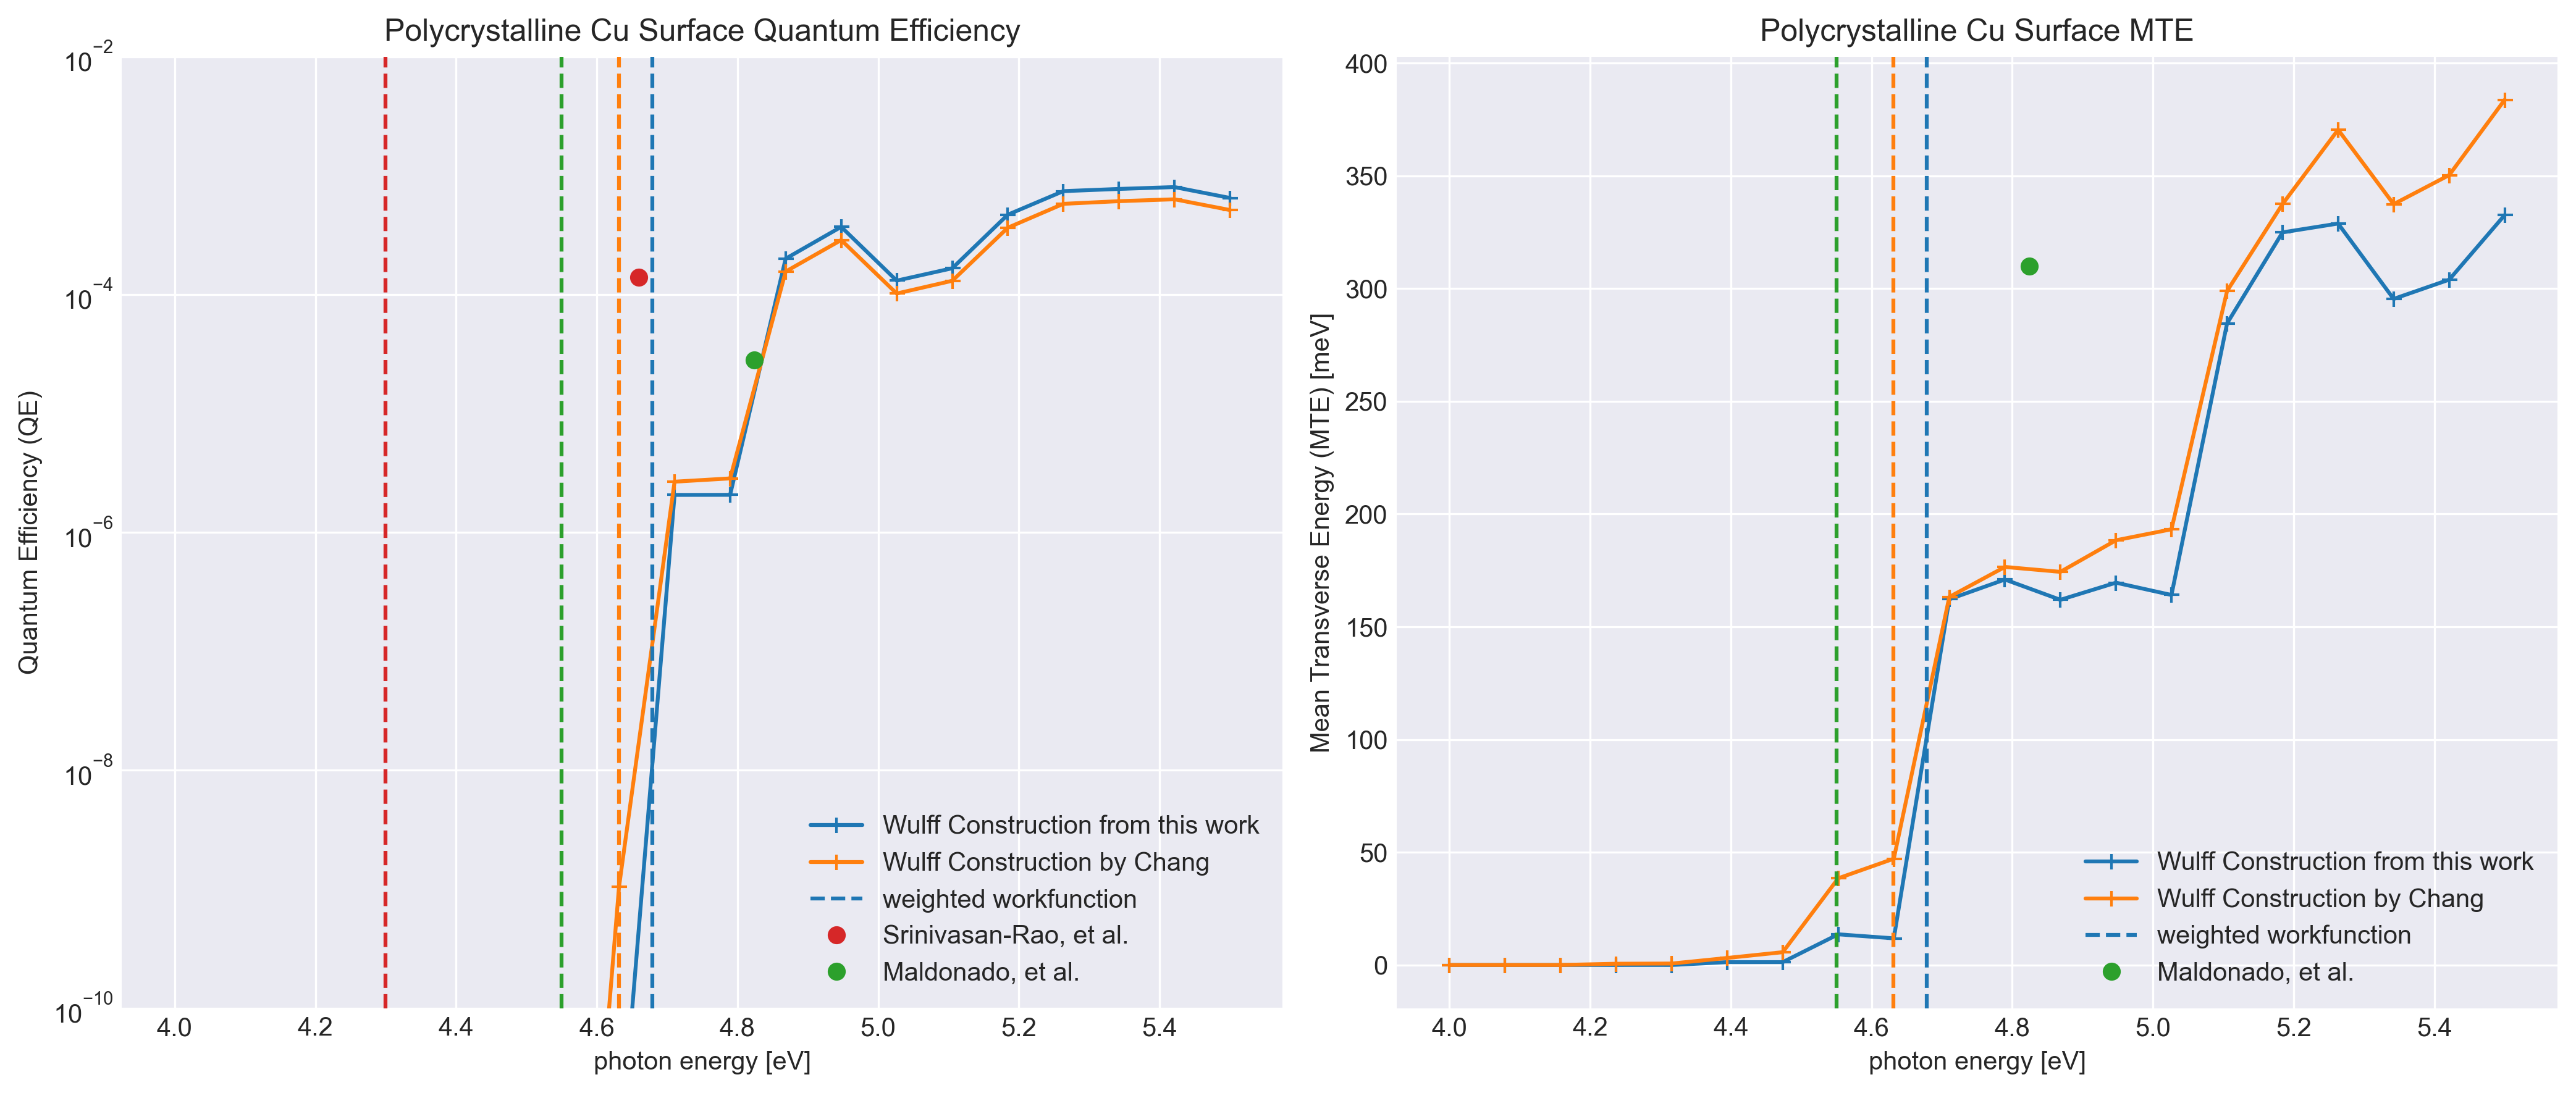

In [63]:
surfaces = [100,110,111]
Cu_surf_data = {}
surface_exp = {111 : np.array([[3.96,23.0],[4.09,35.5],[4.23,77.70],[4.38,57.80],[4.54,105.00],[4.71,156.50],[4.90,266.60],[5.14,336.00],[5.39,520.80]]),
100 : np.array([[4.26,30.6],[4.34,35.1],[4.41,42],[4.49,62.8],[4.58,88.5],[4.66,124.3],[4.71,140.1],[4.81,153.1],[4.9,194.5],[5,257.6],[5.1,262.1],[5.25,312.7],[5.49,386.1]]),
110 : np.array([[4.12,12.9],[4.15,17.7],[4.19,17.2],[4.26,31.9],[4.34,60.8],[4.41,92.6],[4.49,121.3],[4.54,141],[4.66,170.5],[4.71,208.4],[4.81,227.9],[4.9,263.5],[5,304.9],[5.1,286.6],[5.21,353.9],[5.3,435.3],[5.49,453.1]])}

wulff_calced = {100:0.2177,110:0.0,111:0.7823}
wulff_victor = {100:0.269,110:0.127,111:0.604}

for surface in surfaces:
    Cu_surf_data[surface] = read_photonsweep_outputs(seed = '', path = f'./structures/Cu{surface}_60/')
    Cu_surf_data[surface]['experimental'] = surface_exp[surface]
    if len(Cu_surf_data[surface]['bloch']) == len(Cu_surf_data[surface]['free electron']):
        Cu_surf_data[surface]['mean'] = 0.5*Cu_surf_data[surface]['bloch']+0.5*Cu_surf_data[surface]['free electron']

graph_options = {
    'title': 'Polycrystalline Cu Surface',
    'temperature': 298,
    'plottype' : 'picture',
    'filename' : f'./structures/plots/Cu_polycryst_QE_MTE.png'
}

Cu_surf_weighted = {'calced':{},'victor':{}}

for item in Cu_surf_weighted.keys():
    Cu_surf_weighted[item]['photon_energy'] = Cu_surf_data[100]['mean'][:,0]
    Cu_surf_weighted[item]['qe'] = np.zeros([len(Cu_surf_data[100]['mean'])])
    Cu_surf_weighted[item]['mte'] = np.zeros([len(Cu_surf_data[100]['mean'])])
    Cu_surf_weighted[item]['exp_mte'] = np.zeros([len(Cu_surf_data[100]['mean'])])
    Cu_surf_weighted[item]['workfct'] = 0
#print(Cu_surf_data)
#print(Cu_surf_weighted)

for surface in Cu_surf_data.keys():
    Cu_surf_weighted['calced']['qe'] = Cu_surf_weighted['calced']['qe'] + wulff_calced[surface] * Cu_surf_data[surface]['mean'][:,1] 
    Cu_surf_weighted['calced']['mte'] = Cu_surf_weighted['calced']['mte'] + wulff_calced[surface] * Cu_surf_data[surface]['mean'][:,2]
    Cu_surf_weighted['calced']['workfct'] = Cu_surf_weighted['calced']['workfct'] + wulff_calced[surface] * Cu_surf_data[surface]['workfct']

    
    Cu_surf_weighted['victor']['qe'] = Cu_surf_weighted['victor']['qe'] + wulff_victor[surface] * Cu_surf_data[surface]['mean'][:,1] 
    Cu_surf_weighted['victor']['mte'] = Cu_surf_weighted['victor']['mte'] + wulff_victor[surface] * Cu_surf_data[surface]['mean'][:,2]  
    Cu_surf_weighted['victor']['workfct'] = Cu_surf_weighted['victor']['workfct'] + wulff_victor[surface] * Cu_surf_data[surface]['workfct']

#print(Cu_surf_weighted)

fig, ax = plt.subplots(1,2, figsize = (14,6), dpi = 300)
plt.style.use('seaborn-darkgrid')
ax[0].plot(Cu_surf_weighted['calced']['photon_energy'],Cu_surf_weighted['calced']['qe'],c = 'tab:blue', marker = '+',label = "Wulff Construction from this work" )
ax[0].plot(Cu_surf_weighted['victor']['photon_energy'],Cu_surf_weighted['victor']['qe'], c = 'tab:orange', marker = '+',label = "Wulff Construction by Chang" )
ax[1].plot(Cu_surf_weighted['calced']['photon_energy'],[x*1000 for x in Cu_surf_weighted['calced']['mte']],c = 'tab:blue', marker = '+', label =  "Wulff Construction from this work")
ax[1].plot(Cu_surf_weighted['victor']['photon_energy'],[x*1000 for x in Cu_surf_weighted['victor']['mte']],c = 'tab:orange', marker = '+', label =  "Wulff Construction by Chang")
ax[0].axvline(Cu_surf_weighted['calced']['workfct'], ls = '--', c = 'tab:blue', label = 'weighted workfunction')
ax[0].axvline(Cu_surf_weighted['victor']['workfct'], ls = '--', c = 'tab:orange')
ax[1].axvline(Cu_surf_weighted['calced']['workfct'], ls = '--', c = 'tab:blue', label = 'weighted workfunction')
ax[1].axvline(Cu_surf_weighted['victor']['workfct'], ls = '--', c = 'tab:orange')
ax[0].plot(4.66,1.4e-4,marker = 'o',linestyle = 'None',markerfacecolor='tab:red', markeredgecolor='tab:red', label = 'Srinivasan-Rao, et al.')
ax[1].plot(4.824, 310,marker = 'o',linestyle = 'None' ,markerfacecolor='tab:green', markeredgecolor='tab:green', label = 'Maldonado, et al.')
ax[0].plot(4.824, 2.8e-5,marker = 'o',linestyle = 'None' ,markerfacecolor='tab:green', markeredgecolor='tab:green', label = 'Maldonado, et al.')
ax[0].axvline(4.55, ls = '--', c = 'tab:green')
ax[1].axvline(4.55, ls = '--', c = 'tab:green')
#ax[0].plot(4.66+(Cu_surf_weighted['calced']['workfct']-4.3),1.4e-4,marker = 'o',markerfacecolor='tab:red', markeredgecolor='tab:red')
ax[0].axvline(4.3, ls = '--', c = 'tab:red')
#ax[0].errorbar(4.66,)
#ax[0].axvline(4.55, ls = '--', c = 'tab:yellow')
ax[0].set(xlabel = 'photon energy [eV]', ylabel = 'Quantum Efficiency (QE)', title = f"{graph_options['title']} Quantum Efficiency", yscale='log', ylim = [1e-10, 1e-2])
ax[1].set(xlabel = 'photon energy [eV]', ylabel = 'Mean Transverse Energy (MTE) [meV]', title = f"{graph_options['title']} MTE")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig(graph_options['filename'],dpi = 250)

In [25]:
Cu_surf_data = read_photonsweep_outputs(seed = 'Cu_surf_111', path = './structures/Cu_surf_111/')
graph_options = {
    'title': 'Cu[111]',
    'temperature': 298,
    'filename' : './structures/plots/Cu_111_pbesol_120deg_test2_mte_plot_0E.png'
}
#print(Cu_111_data)
fig, ax = make_photonsweep_plots(Cu_surf_data,**graph_options)
plt.savefig(graph_options['filename'],dpi = 250)

KeyError: 'plottype'

### Plot DOS plot created by OptaDOS

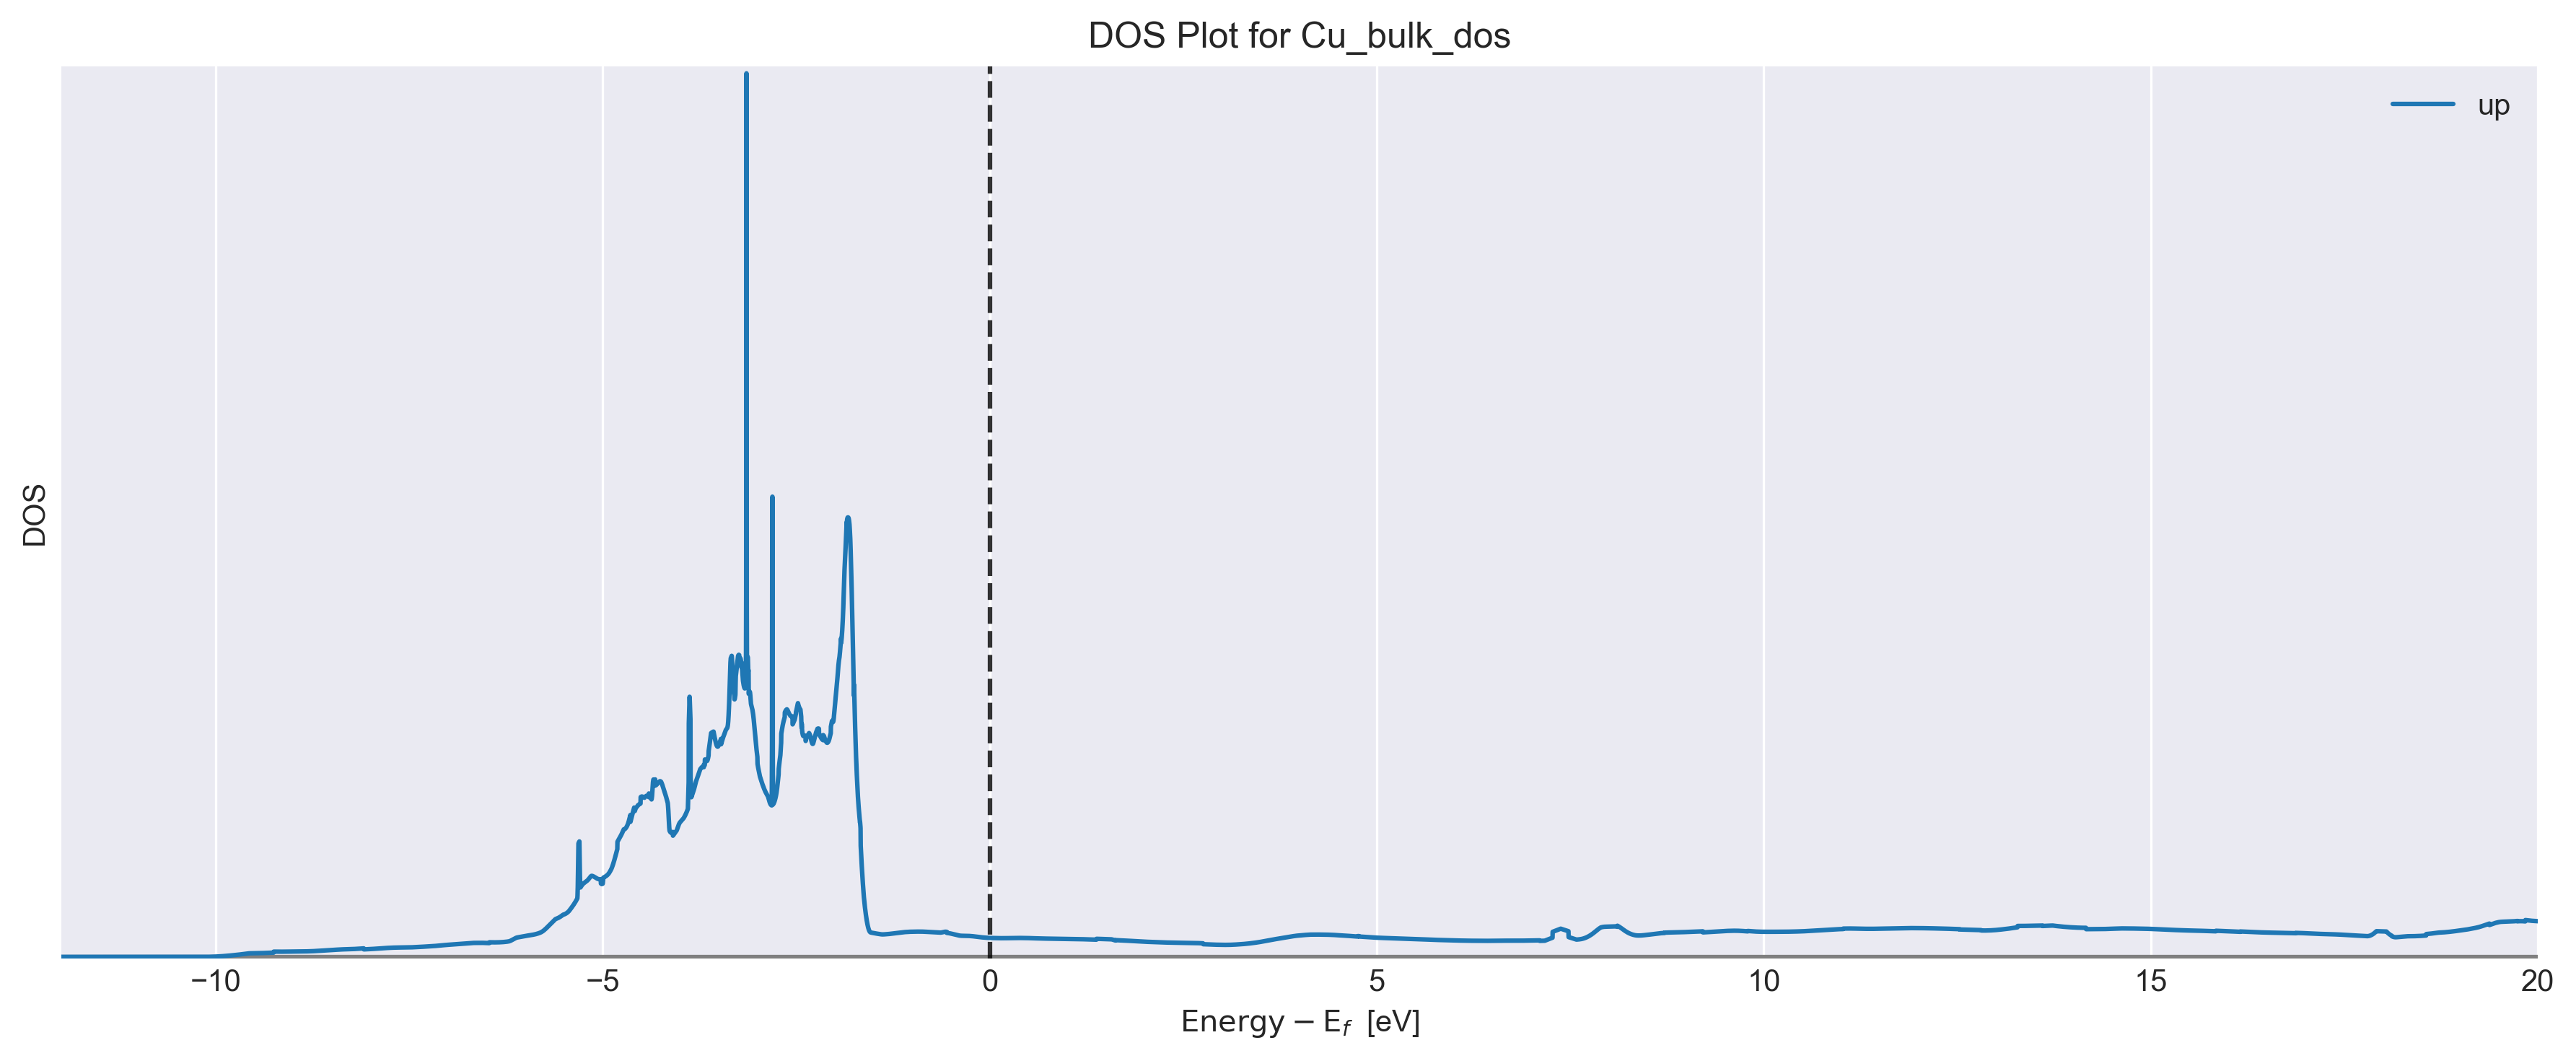

In [3]:
seed = './structures/Cu_bulk_PBEsol_fixed/'
fig, ax= plot_dos_optados(seed, plot_total = False, xlimit = (-12, 20), export_json = True)
#plt.savefig(f"./structures/plots/{seed}_dos.png")

{<Spin.up: 1>: array([0., 0., 0., ..., 0., 0., 0.])}


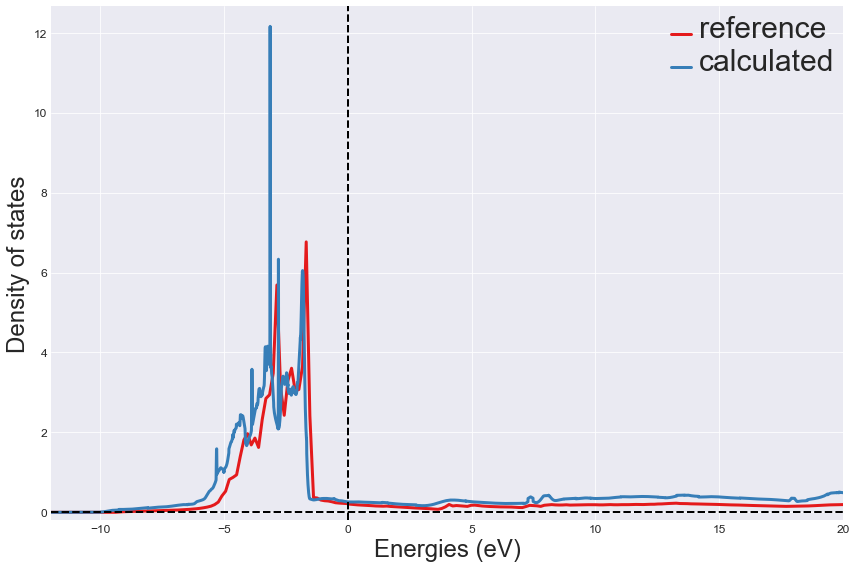

In [10]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu_bulk_PBEsol_linear_0.05_dos_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_matproject_ref.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("calculated", dos_calc)
plotter.add_dos("reference", dos_ref)
print(dos_calc.densities)
plotter.get_plot(xlim = (-12,20),ylim = (-0.2,max(dos_calc.densities[Spin.up])+0.5))
plt.savefig('./structures/plots/Cu_bulk_PBEsol_linear_tot_dos_comparison_matproj.png')

### Plot proj DOS plot created by OptaDOS

dict_keys(['Cu1,Cu1,Cu1,Cu1', 'Cu2,Cu2,Cu2,Cu2', 'Cu3,Cu3,Cu3,Cu3', 'Cu4,Cu4,Cu4,Cu4', 'Cu5,Cu5,Cu5,Cu5', 'Cu6,Cu6,Cu6,Cu6', 'Cu7,Cu7,Cu7,Cu7', 'Cu8,Cu8,Cu8,Cu8', 'Cu9,Cu9,Cu9,Cu9', 'Cu10,Cu10,Cu10,Cu10', 'Cu11,Cu11,Cu11,Cu11', 'Cu12,Cu12,Cu12,Cu12', 'Cu13,Cu13,Cu13,Cu13', 'Cu14,Cu14,Cu14,Cu14'])
[['Cu', '1', 's'], ['Cu', '1', 'p'], ['Cu', '1', 'd'], ['Cu', '1', 'f']]


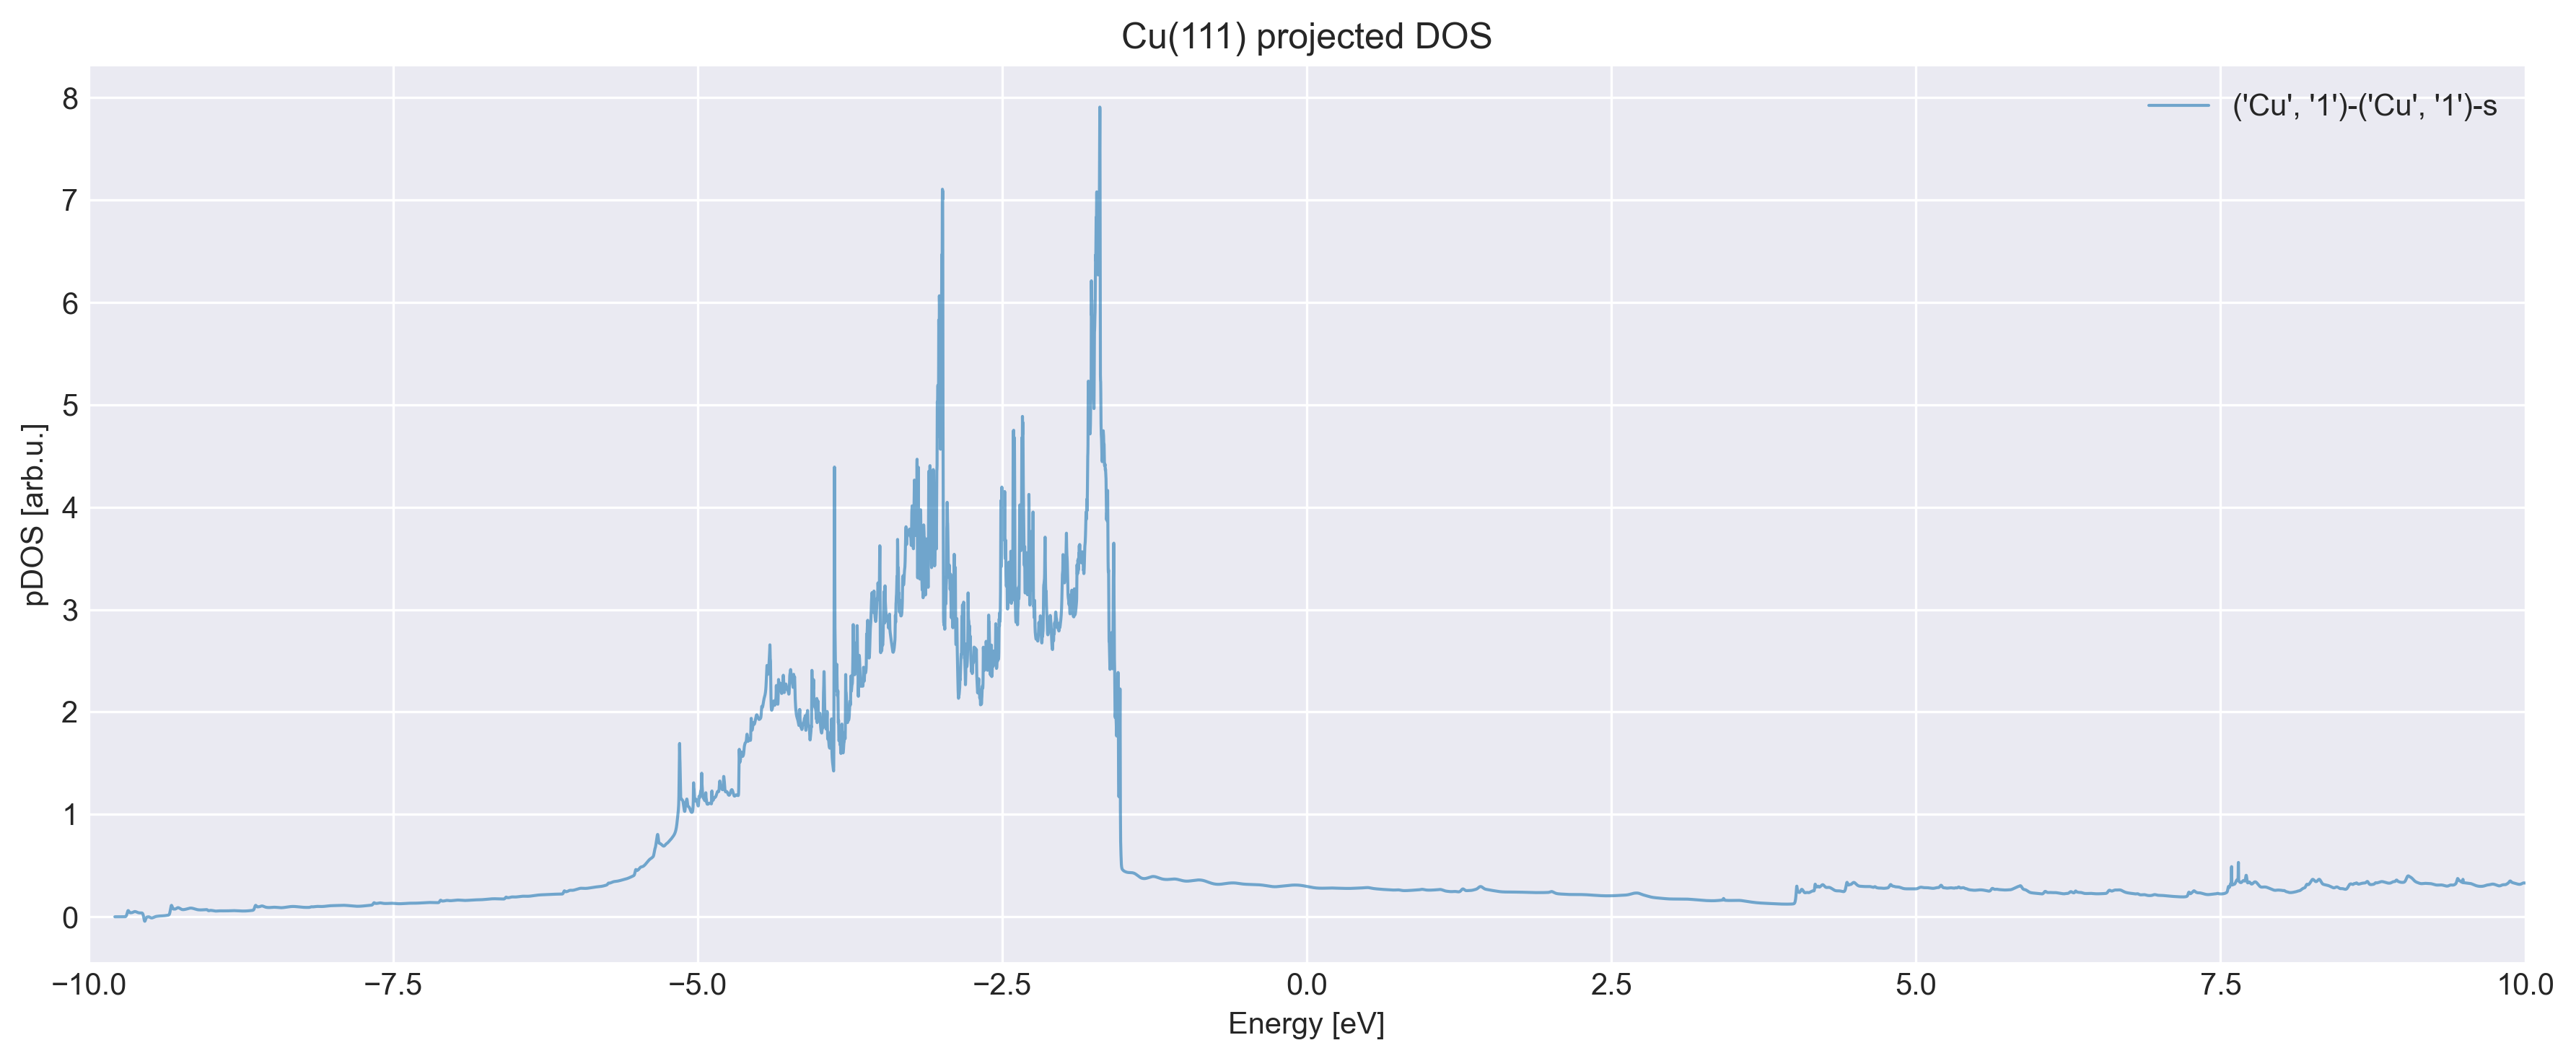

In [26]:
#seed = 'Cu_bulk_spectral_pdos'
path='./structures/layer_convergence/111/'
data = read_proj_dos_optados(path = path, export_json=False)
print(data['projections'].keys())#['Cu1,Cu1,Cu1,Cu1'])
#print(data['spin channels'])
atom = 'Cu7,Cu7,Cu7,Cu7'
data['projections'] = {atom: data['projections'][atom]}
#print(data['projections'].keys())
density = {Spin.up : data['projections'][atom]['s']}
energies = data['energies']
output_dos = Dos(0, energies,density)
seed = 'Cu111_16L_middle_layer'
with open(f'./structures/jsons/DOS/{seed}_total.json', 'w') as f:
    json.dump(output_dos.as_dict(), f)  
eins,axis = plot_proj_dos_optados(data,xlimit=(-10, 10))
plt.title('Cu(111) projected DOS')
plt.xlabel('Energy [eV]')
plt.ylabel('pDOS [arb.u.]')
plt.tight_layout()
plt.savefig('./structures/plots/Cu111_50_middle_layer_-10_10.png',dpi=500)

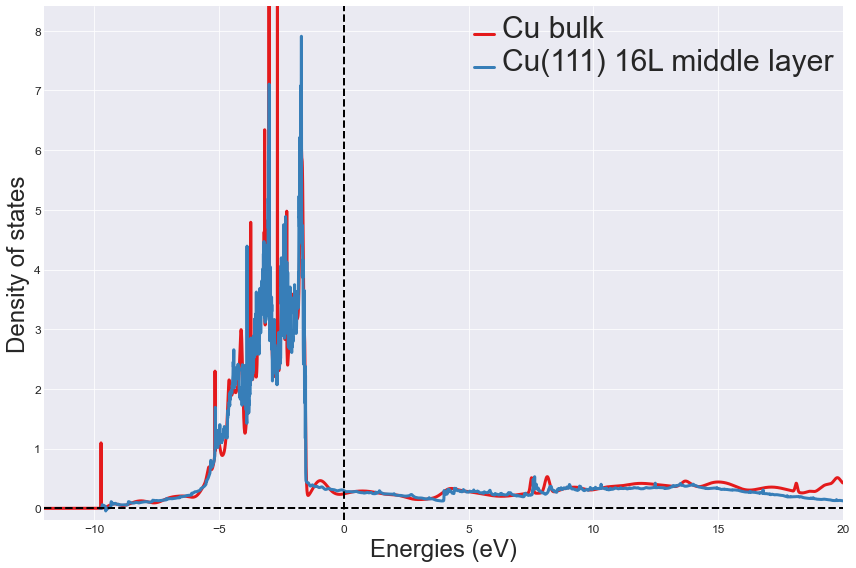

In [27]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu111_16L_middle_layer_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_PBEso_adaptivel_dos_total.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("Cu(111) 16L middle layer", dos_calc)
plotter.add_dos("Cu bulk", dos_ref)
#print(dos_calc.densities)
plotter.get_plot(xlim = (-12,20),ylim = (-0.2,max(dos_calc.densities[Spin.up])+0.5))
plt.savefig('./structures/plots/Cu111_PBEsol_16L_middle_comparison_matproj.png')

### Plot joint DOS created by OptaDOS

In [ ]:
data_10060 = get_joint_dos_optados('./structures/Cu_surf_100_victor_60A/')
label_1 = 'Cu100_60A'
data_10050 = get_joint_dos_optados('./structures/Cu110_victor_60A/')
label_2 = 'Cu110_60A'
data_11160 = get_joint_dos_optados('./structures/Cu_surf_111_victor_60A/')
label_3= 'Cu111_60A'
fig,ax = plot_joint_dos_optados(data_10060, label=label_1, xlimit =[0,6])
fig,ax = add_jdos_line(data_10050,fig,ax,label=label_2)
fig,ax = add_jdos_line(data_11160,fig,ax,label=label_3)
ax.set_title('Joint DOS for Cu')
plt.legend()
plt.savefig('./structures/plots/Cu_jdos_comparison_6.png')

In [ ]:
data_11160 = get_joint_dos_optados('./structures/Cu_surf_111_victor_60A/')
label_1 = 'Cu111_60A'
data_11150 = get_joint_dos_optados('./structures/Cu_surf_111_victor_50A/')
label_2 = 'Cu111_50A'
fig,ax = plot_joint_dos_optados(data_11160, label=label_1, xlimit =[0,6])
fig,ax = add_jdos_line(data_11150,fig,ax,label=label_2)
ax.set_title('Joint DOS for Cu[111]')
plt.legend()
plt.savefig('./structures/plots/Cu111_jdos_comparison.png')

## Plot DOS from json files

In [ ]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu_bulk_spectral_dos_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_matproject_ref.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("calculated", dos_calc)
plotter.add_dos("reference", dos_ref)
plotter.get_plot(xlim = (-12,2.5),ylim=(-0.2,9))
plt.savefig('./structures/plots/Cu_bulk_tot_dos_comparison_dos_matproj_zoom.png')

In [ ]:
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_full = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full_UX.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_ux = BandStructureSymmLine.from_dict(d)
bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
    json.dump(bandstruct_full.as_dict(), f)
plotter = BSPlotter(bandstruct_full)
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

In [ ]:
with open('./structures/jsons/bands/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_ref = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/cu_bandstruct_all_points.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_full = BandStructureSymmLine.from_dict(d)

#bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
#with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
#    json.dump(bandstruct_full.as_dict(), f)

plotter = BSPlotter(bandstruct_cu_full)
plotter.add_bs(bandstruct_cu_ref)
band_plot = plotter.get_plot(ylim=(-12,35), bs_labels=['Calculated','Materials Project Ref'])
plt.xlabel('')
plt.savefig('comparison_calculated_vs_matproj_ref_optados_Efermi.png')
band_plot.show()


In [ ]:
def modified_potential_plot(directory:str=None, bounds = None,centered:bool = True,mod_odi:bool = True):
    if directory == None:
        directory = f'./structures/' 
    if directory[-1] != '/': directory += '/'
    listOfFiles = os.listdir(directory)
    found = [False,False]
    for item in listOfFiles:
        if '.pot_fmt' in item and not '.dat' in item:
            found[0] = True
            path = directory + item
            x, potential,cell = average_potential_from_file(path, potential = True)
        if '_all.odo' in item:   
            odo_pth = directory + item
            fermi_level = OptaDOSOutput(odo_pth).fermi_e
            found[1] = True
        if False not in found: break
    if False in found: 
        file = ['Potential File (.pot_fmt)','Opatdos File (_all.odo)']
        for item in found: 
            if item == False:
                raise OSError(2, f'No {file[found.index[item]]} found!')
    indices = [0,0]
    stepsize = x[1] - x[0]
    if not centered and bounds == None: bounds = [(x[-1]/2)-1,(x[-1]/2)+1]
    if centered and bounds == None: bounds =[0,5]
    #print(fermi_level.path)
    seed = path.split('/')[-1].split('.')[0]
    for index, item in enumerate(x):
        if abs(item - bounds[0]) <= stepsize: indices[0] = index
        if abs(item - bounds[1]) <= stepsize: indices[1] = index
        if item > (bounds[1]+3*stepsize): break
    vacuum_level = np.mean(potential[indices[0]:indices[1]])
    print(plt.style.available)
    plt.style.use('seaborn-poster')
    fig, ax = plt.subplots(1,1, figsize = (5,4), dpi = 300)
    plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False,left=False,right=False,labelleft=False)
     #ax.hlines(vacuum_level, 0, max(x), ls = '--',colors = 'r', linewidth = 1, label= 'Vacuum Level')
    ax.hlines(fermi_level,0,max(x), ls = '--', colors = 'r', linewidth=1.5, label='Fermi Energy')
    #ax.vlines(bounds,vacuum_level-1, vacuum_level+1,colors = 'k',linewidth = 1, label = 'bounds')
    ax.plot(x,potential,linewidth = 1.5, label = 'Potential')
    #ax.text(max(x)/2,vacuum_level-2,f'vacuum level = {round(vacuum_level,5)} eV',ha='center')
    #ax.text(max(x)/2,fermi_level - 2,f'fermi level = {round(fermi_level,5)} eV',ha='center')
    #ax.set_title(f'{seed} - Workfunction W = {round(vacuum_level-fermi_level,5)}')
    ax.set(xlim = (0,max(x)/2+5),xlabel = r'z', ylabel = 'Energy',ylim = [min(potential)-2,max(potential) + 20])
    #ax.legend(loc='best')
    if mod_odi:             
        for item in listOfFiles:
            if '_photo.odi' in item:
                print('Writing work_function=', round(vacuum_level-fermi_level,5),f'eV to {item}')
                subprocess.call(f'sed -i "s/.*work_function.*/work_function : {round(vacuum_level-fermi_level,5)}/" {directory}{item}',shell=True)

    return fig,ax;

In [ ]:
fig, ax = modified_potential_plot('./structures/Cu111_60/')
plt.savefig('./structures/plots/poster_fig_steps.png')

In [ ]:
def modified_proj_dos_optados(path:str=None, plot_up:bool = True, plot_down:bool = False, plot_total:bool = False, xlimit = None, export_json = False,):
    energies, total= [],[]
    columns, projections, column_keys, totals = {}, {}, {}, {Spin.up:[], Spin.down:[]}
    plt.style.use('seaborn-poster')
    fig, ax = plt.subplots(1,1, figsize = (10,5), dpi = 300)
    header_string = '#+----------------------------------------------------------------------------+'
    header, values = [],[]
    spin_channels = False
    shifted_efermi = False
    if path == None:
        path = f'./structures/'
    listOfFiles = os.listdir(path)
     # create output classes for each of the output files
    found=[False,False]
    for item in listOfFiles:
        if '_all.odo' in item:
            seed = item.replace('_all.odo','')
            with open(path + item,'r') as g:
                for line in g:
                    if 'Shift energy scale so fermi_energy=0' in line: shifted_efermi = bool(line.split()[7]=='True')
                    if 'Projected Density Of States Calculation' in line:
                        for i in range(6): line = next(g)
                        if 'Fermi energy' in line: efermi = float(line.split()[6])
                        else: print('No fermi energy found, check cursor position!')
            found[0] = True
        if '.pdos.dat' in item:
            with open(path+item,'r') as f:
                for line in f:
                    line_values = line.strip().split()
                    if '#' in line_values[0]:
                        header.append(line_values)
                    else:
                        values.append(line_values)
            found[1] = True
    files=[f'Optados Output',f'pDOS Data File']
    for index,item in enumerate(found):
        if item == False:
            raise  OSError(2, f'No {files[index]} found!')
    for i, item in enumerate(header):
        if 'Column:' in item:
            columns[item[2]] = []
            t = i+2
            while header_string not in header[t]:
                columns[item[2]].append(header[t][1:-1])
                t += 1
    if len(columns['1'][0])>3: spin_channels = True
    #print(columns)
    for key in columns.keys():                                                              # Go through each of the columns read in from the header
        current = columns[key]                                                              # Load the array with the information for the current column, each Atom included has its own array (for example Cu1, Cu2)
        atom = ''
        for item in current:                                                                # Generate string with atoms or sites included in column projector 
            if atom != '':
                atom += ','
            atom += (f'{item[0]}{item[1]}') 
        orbital = current[0][2]                                                             # Read in the orbital projection for this column
        column_keys[key] = [atom,orbital]                                                   # Set the information for that generated column key with information on projector constituents and orbitals
        if atom not in projections.keys():projections[atom] = {}
        if spin_channels:                                                                   # If spin channel is included in the file, initialise initialise projections as {atom: { orbital1: { Spin1: [], ...} , ... } }                    # Initialise atom dict
            if orbital not in projections[atom].keys():projections[atom][orbital] = {}      # Initialise orbital dict
            if spin_channels and current[0][3] in ['Up','Down']: 
                spin = current[0][3]
                if spin not in projections[atom][orbital].keys(): 
                    projections[atom][orbital][spin] = []                                   # initialise spin channel array
                    column_keys[key].append(spin)                                           # Append pin channel to generated column key tuple
        else:                                                                               # If no spin channel is included in the file, initialise projections as {atom: {orbital1: [], ... }}
            if orbital not in projections[atom].keys():projections[atom][orbital] = []
    for item in values:
        item = [float(i) for i in item]
        if not all(abs(elem) == item[1] for elem in item[1:]):
            if not shifted_efermi: energies.append(item[0]-efermi)
            else: energies.append(item[0])
            temp_total, temp_up, temp_down = 0,0,0
            for i in range(len(item[1:])):
                keys = column_keys[str(i+1)]
                if spin_channels:
                    local_dos = float(item[i+1])
                    projections[keys[0]][keys[1]][keys[2]].append(local_dos)
                    if keys[2] == 'Down':
                        temp_total += local_dos * -1
                        temp_down += local_dos
                    else:
                        temp_total += local_dos
                        temp_up += local_dos
                else:
                    projections[keys[0]][keys[1]].append(float(item[i+1]))
                    temp_total = temp_total + float(item[i+1])
            total.append(temp_total)
            totals[Spin.up].append(temp_up)
            totals[Spin.down].append(temp_down)
    if plot_total: ax.plot(energies, total, label = f"{atom}-total", alpha = 0.8,lw = 1)
    for atom in projections.keys():
        for orbital in projections[atom]:
            if spin_channels:
                if plot_up: 
                    if not all(abs(elem) == 0.0 for elem in projections[atom][orbital]['Up']): 
                        ax.plot(energies, projections[atom][orbital]['Up'], label = f"{columns[columns.keys()[0]]}-{columns[columns.keys()[-1]]}-{orbital}-Up",alpha = 0.6, lw = 2)
                if plot_down: 
                    if not all(abs(elem) == 0.0 for elem in projections[atom][orbital]['Down']): 
                        ax.plot(energies, projections[atom][orbital]['Down'], label = f"{atom}-{orbital}-Down", alpha = 0.6,lw = 2)
            else:
                keys = columns['1']
                print(keys)
                if not all(abs(elem) == 0.0 for elem in projections[atom][orbital]): 
                    ax.plot(energies, projections[atom][orbital], label = f"{keys[0][0],keys[0][1]}-{keys[-1][0],keys[-1][1]}-{orbital}", alpha = 0.6,lw = 2)
    if xlimit == None: ax.set(xlim = (min(energies),max(energies)))
    else: ax.set(xlim = xlimit)
    #plt.legend()
    if export_json:                                                             # Export currently gives errors due to inconsistencies within pymatgen DOS class                                                             
        cell = read_cell2pmg(path = f"./structures/{seed}/{seed}.cell")
        tot_dos = Dos(energies = energies, densities = totals,efermi = 0)
        proj_dos = CompleteDos(cell, total_dos = tot_dos, pdoss = projections)
        with open(f'./structures/jsons/DOS/{seed}.json', 'w') as f:
            json.dump(proj_dos.as_dict(), f)
    return fig,ax;

In [ ]:
fig,ax=modified_proj_dos_optados(path = './structures/Cu111_60/',xlimit = [10,-10])
plt.savefig('./structures/plots/Cu_111_60_pDOS_plot_poster.png',dpi = 500)